##**Notebook PC#08** -- Sunspot dataset e respostas
## Simple Recurrent Neural Network, Linear Predictor, MLP and LSTM for multi-step time series prediction.<BR>

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** Gabriel Toffanetto França da Rocha - 289320<br>
**Aluno(a):** Maria Fernanda Paulino Gomes - 206745<br>


In [2]:
# Loading all the relevant libraries
from google.colab import drive
from pandas import read_csv
from pandas import DataFrame
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

## **A base [unemployment rate] foi baixada no [link](https://fred.stlouisfed.org/series/UNRATE).**

In [3]:
# Montar o Google Drive
drive.mount('/content/drive')

# Structuring the dataset from a single time series, scaling and spliting into training / testing
def get_train_test(dataset, split_percent, time_steps, horizon):
    df = read_csv(dataset, usecols=[1], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    # There is a kind of data leakage in the next command
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    df = DataFrame()
    for i in range(0,time_steps):
      df['t-' + str(time_steps-i-1)] = [data[j] for j in range(i, (len(data)-horizon-time_steps+i+1))]
    for i in range(1,horizon+1):
      df['t+' + str(i)] = [data[j] for j in range(time_steps+i-1, (len(data)-horizon+i))]
    print(df)
    df1 = df.copy()
    for i in range(1,horizon+1):
      df1 = df1.drop(['t+' + str(i)], axis = 1)
    dataX = np.array(df1) #separacao de dados de time_steps
    df2 = df['t+1']
    for i in range(2,horizon+1):
      df2 = pd.concat([df2, df['t+' + str(i)]], axis=1)
    datay = np.array(df2) #separacao de dados de horizon
    # Point for splitting data into train and test
    split = int(n*split_percent)
    X = dataX[range(split),:]
    y = datay[range(split)]
    Xt = dataX[split:,:]
    yt = datay[split:]
    return X, y, Xt, yt

time_steps = 11
horizon = 3
# Defina o caminho para o arquivo no Google Drive (certifique-se de que o arquivo foi movido para "Meu Drive")
file_path = '/content/drive/My Drive/Colab Notebooks/PC06-12/monthly_sunspot.csv'
# Here you will decide which dataset to consider.
# X, y, Xt, yt = get_train_test('unemployment_rate.csv', 0.8, time_steps, horizon)
X, y, Xt, yt = get_train_test(file_path, 0.8, time_steps, horizon)

Mounted at /content/drive
          t-10       t-9       t-8       t-7       t-6       t-5       t-4  \
0     0.228526  0.246651  0.275808  0.219464  0.334909  0.328999  0.373522   
1     0.246651  0.275808  0.219464  0.334909  0.328999  0.373522  0.261229   
2     0.275808  0.219464  0.334909  0.328999  0.373522  0.261229  0.299054   
3     0.219464  0.334909  0.328999  0.373522  0.261229  0.299054  0.297478   
4     0.334909  0.328999  0.373522  0.261229  0.299054  0.297478  0.624901   
...        ...       ...       ...       ...       ...       ...       ...   
2802  0.418046  0.423956  0.468085  0.373128  0.386525  0.500394  0.332151   
2803  0.423956  0.468085  0.373128  0.386525  0.500394  0.332151  0.200946   
2804  0.468085  0.373128  0.386525  0.500394  0.332151  0.200946  0.262017   
2805  0.373128  0.386525  0.500394  0.332151  0.200946  0.262017  0.317967   
2806  0.386525  0.500394  0.332151  0.200946  0.262017  0.317967  0.390859   

           t-3       t-2       t-1   

In [4]:
print(X.shape)
print(y.shape)

(2256, 11)
(2256, 3)


## **Implementing the simple recurrent neural network**

In [5]:
# Execute this cell or the cell associated with one of the other predictors. They are mutually exclusive.
def create_RNN(hidden_units, dense_units, input_shape, activation):
        model = Sequential()
        model.add(SimpleRNN(hidden_units, activation=activation[0], input_shape=input_shape))
        model.add(Dense(units=dense_units, activation=activation[1]))
        model.compile(loss='mean_squared_error', optimizer='adam')
        return model

def RNN_predictor (X, y, time_steps):
    model = create_RNN(hidden_units=30, dense_units=horizon, input_shape=(time_steps,1), activation=['tanh', 'tanh'])
    train_predict = model.fit(X, y, epochs=20, batch_size=1, verbose=2)
    return model

RNN_model = RNN_predictor(X, y, time_steps)

Epoch 1/20
2256/2256 - 8s - loss: 0.0060 - 8s/epoch - 3ms/step
Epoch 2/20
2256/2256 - 6s - loss: 0.0047 - 6s/epoch - 3ms/step
Epoch 3/20
2256/2256 - 8s - loss: 0.0048 - 8s/epoch - 3ms/step
Epoch 4/20
2256/2256 - 6s - loss: 0.0047 - 6s/epoch - 3ms/step
Epoch 5/20
2256/2256 - 5s - loss: 0.0046 - 5s/epoch - 2ms/step
Epoch 6/20
2256/2256 - 7s - loss: 0.0046 - 7s/epoch - 3ms/step
Epoch 7/20
2256/2256 - 5s - loss: 0.0046 - 5s/epoch - 2ms/step
Epoch 8/20
2256/2256 - 5s - loss: 0.0046 - 5s/epoch - 2ms/step
Epoch 9/20
2256/2256 - 7s - loss: 0.0046 - 7s/epoch - 3ms/step
Epoch 10/20
2256/2256 - 5s - loss: 0.0046 - 5s/epoch - 2ms/step
Epoch 11/20
2256/2256 - 6s - loss: 0.0046 - 6s/epoch - 3ms/step
Epoch 12/20
2256/2256 - 6s - loss: 0.0046 - 6s/epoch - 2ms/step
Epoch 13/20
2256/2256 - 5s - loss: 0.0045 - 5s/epoch - 2ms/step
Epoch 14/20
2256/2256 - 7s - loss: 0.0046 - 7s/epoch - 3ms/step
Epoch 15/20
2256/2256 - 5s - loss: 0.0045 - 5s/epoch - 2ms/step
Epoch 16/20
2256/2256 - 6s - loss: 0.0046 - 6s/ep

In [ ]:
# [Do not run this cell] or [Upload the PNG file and then run].
# Configuration of the simple RNN
from IPython.display import Image
Image("RNN_info_flow.png", width = 600, height = 300)

In [7]:
wx = RNN_model.get_weights()[0]
wh = RNN_model.get_weights()[1]
bh = RNN_model.get_weights()[2]
wy = RNN_model.get_weights()[3]
by = RNN_model.get_weights()[4]
print(wx.shape)
print(wh.shape)
print(bh.shape)
print(wy.shape)
print(by.shape)

(1, 30)
(30, 30)
(30,)
(30, 3)
(3,)


## **Implementing a linear predictor**

In [8]:
# Execute this cell or the cell associated with one of the other predictors. They are mutually exclusive.
def linear_predictor(X,y):
    model = LinearRegression()
    train_predict = model.fit(X, y)
    print(model.coef_)
    print(model.intercept_)

    return model

linear_model = linear_predictor(X,y)

[[-0.03231146 -0.03466097  0.07275847  0.00478093 -0.01082086  0.0669384
   0.04085789  0.08718769  0.07405268  0.13080613  0.5568415 ]
 [-0.08074499 -0.01733866  0.01364125  0.08068237  0.00291312  0.03024416
   0.09379476  0.09038365  0.12686113  0.15160784  0.43763587]
 [-0.10533409 -0.04564735  0.02615331  0.02253815  0.08277366  0.03709105
   0.05409302  0.13282879  0.12137729  0.19044921  0.3907065 ]]
[0.00763167 0.01236634 0.01638974]


## **Implementing the multilayer perceptron neural network (MLP)**

In [9]:
# Execute this cell or the cell associated with one of the other predictors. They are mutually exclusive.
def MLP_predictor():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(80, activation=tf.nn.tanh),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(horizon, activation='linear')
  ])
  model.compile(optimizer='adam', loss='mean_squared_error')
  train_predict = model.fit(X, y, epochs=100)
  model.summary()

  return model

MLP_model = MLP_predictor()

Epoch 1/100
71/71 [==============================] - 1s 2ms/step - loss: 0.0214
Epoch 2/100
71/71 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 3/100
71/71 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 4/100
71/71 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 5/100
71/71 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 6/100
71/71 [==============================] - 0s 2ms/step - loss: 0.0058
Epoch 7/100
71/71 [==============================] - 0s 2ms/step - loss: 0.0056
Epoch 8/100
71/71 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 9/100
71/71 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 10/100
71/71 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 11/100
71/71 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 12/100
71/71 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 13/100
71/71 [=================

## **Implementing the long short-term memory network (LSTM)**

In [10]:
def LSTM_predictor(X, y, time_steps):
    X1 = X.reshape(X.shape[0],time_steps,1)
    model=Sequential()
    model.add(LSTM(25,input_shape=(time_steps,1)))
    model.add(Dense(horizon,activation='linear'))
    model.compile(loss='mean_squared_error',optimizer='adam')

    train_predict = model.fit(X1,y,epochs=200,verbose=2)

    return model

LSTM_model = LSTM_predictor(X, y, time_steps)
print(LSTM_model.summary())

Epoch 1/200
71/71 - 2s - loss: 0.0217 - 2s/epoch - 32ms/step
Epoch 2/200
71/71 - 0s - loss: 0.0065 - 347ms/epoch - 5ms/step
Epoch 3/200
71/71 - 0s - loss: 0.0059 - 374ms/epoch - 5ms/step
Epoch 4/200
71/71 - 0s - loss: 0.0055 - 355ms/epoch - 5ms/step
Epoch 5/200
71/71 - 0s - loss: 0.0053 - 356ms/epoch - 5ms/step
Epoch 6/200
71/71 - 0s - loss: 0.0051 - 362ms/epoch - 5ms/step
Epoch 7/200
71/71 - 0s - loss: 0.0050 - 346ms/epoch - 5ms/step
Epoch 8/200
71/71 - 0s - loss: 0.0050 - 374ms/epoch - 5ms/step
Epoch 9/200
71/71 - 0s - loss: 0.0048 - 362ms/epoch - 5ms/step
Epoch 10/200
71/71 - 0s - loss: 0.0048 - 383ms/epoch - 5ms/step
Epoch 11/200
71/71 - 0s - loss: 0.0048 - 356ms/epoch - 5ms/step
Epoch 12/200
71/71 - 0s - loss: 0.0047 - 363ms/epoch - 5ms/step
Epoch 13/200
71/71 - 0s - loss: 0.0047 - 360ms/epoch - 5ms/step
Epoch 14/200
71/71 - 0s - loss: 0.0046 - 363ms/epoch - 5ms/step
Epoch 15/200
71/71 - 0s - loss: 0.0046 - 355ms/epoch - 5ms/step
Epoch 16/200
71/71 - 0s - loss: 0.0046 - 499ms/epoc

In [11]:
def print_error(trainY, testY, train_predict, test_predict,i):
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('t+%d RMSE train: %.3f RMSE' % (i+1, train_rmse))
    print('t+%d RMSE test: %.3f RMSE' % (i+1, test_rmse))
    return [train_rmse, test_rmse]


def RMSE(train_predict, test_predict):
  rmse = []
  for i in range(horizon):
    if(horizon == 1):
      y1_pred = train_predict
      y1_pred_t = test_predict
      y1 = y
      y1_t = yt
    elif(horizon > 1):
      y1_pred = train_predict[:,i]
      y1_pred_t = test_predict[:,i]
      y1 = y[:,i]
      y1_t = yt[:,i]

    erro = print_error(y1, y1_t, y1_pred, y1_pred_t,i)
    rmse.append(erro)

  # Create a DataFrame from the rmse values for each horizon
  df = pd.DataFrame(rmse)
  df.columns = ['train', 'test']
  return df


In [12]:
# Plot the predictions together with the actual values
def plot_result(trainY, testY, train_predict, test_predict,i):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(30, 6), dpi=300)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Time steps')
    plt.ylabel('Actual and Predicted Values')
    plt.title('t+%d Predition (The Red Line Separates The Training And Test Examples)' % (i+1))
    plt.grid(True)

def plot_predict(train_predict, test_predict, y, yt):
  for i in range(horizon):
    if(horizon == 1):
      y1_pred = train_predict
      y1_pred_t = test_predict
      y1 = y
      y1_t = yt
    elif(horizon > 1):
      y1_pred = train_predict[:,i]
      y1_pred_t = test_predict[:,i]
      y1 = y[:,i]
      y1_t = yt[:,i]
    plot_result(y1, y1_t, y1_pred, y1_pred_t,i)


In [13]:
print ('***** RNN MODEL *****')
train_predict = RNN_model.predict(X)
test_predict = RNN_model.predict(Xt)
df1 = RMSE(train_predict, test_predict)
plot_predict(train_predict, test_predict, y, yt)

Output hidden; open in https://colab.research.google.com to view.

In [14]:
print ('***** LINEAR MODEL *****')
train_predict = linear_model.predict(X)
test_predict = linear_model.predict(Xt)
df2 = RMSE(train_predict, test_predict)
plot_predict(train_predict, test_predict, y, yt)

Output hidden; open in https://colab.research.google.com to view.

In [15]:
print ('***** MLP MODEL *****')
train_predict = MLP_model.predict(X)
test_predict = MLP_model.predict(Xt)
df3 = RMSE(train_predict, test_predict)
plot_predict(train_predict, test_predict, y, yt)

Output hidden; open in https://colab.research.google.com to view.

In [16]:
print ('***** LSTM MODEL *****')
train_predict = LSTM_model.predict(X)
test_predict = LSTM_model.predict(Xt)
df4 = RMSE(train_predict, test_predict)
plot_predict(train_predict, test_predict, y, yt)

Output hidden; open in https://colab.research.google.com to view.

In [17]:
# Plot the prediction error
def plot_result2(trainY, testY, train_predict, test_predict,i):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(30, 6), dpi=300)
    plt.plot(range(rows), actual - predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.xlabel('Time steps')
    plt.ylabel('Actual minus Predicted Values')
    plt.title('t+%d Predition Error (The Red Line Separates The Training And Test Examples)' % (i+1))
    plt.ylim(-0.5, +1.0) # Please, set the interval appropriately, considering all the graphs.
    plt.grid(True)

def plot_error_predict(train_predict, test_predict, y, yt):
    for i in range(horizon):
      if(horizon == 1):
        y1_pred = train_predict
        y1_pred_t = test_predict
        y1 = y
        y1_t = yt
      elif(horizon > 1):
        y1_pred = train_predict[:,i]
        y1_pred_t = test_predict[:,i]
        y1 = y[:,i]
        y1_t = yt[:,i]
      plot_result2(y1, y1_t, y1_pred, y1_pred_t,i)

In [18]:
print ('***** RNN MODEL *****')
train_predict = RNN_model.predict(X)
test_predict = RNN_model.predict(Xt)
plot_error_predict(train_predict, test_predict, y, yt)


Output hidden; open in https://colab.research.google.com to view.

In [19]:
print ('***** LINEAR MODEL *****')
train_predict = linear_model.predict(X)
test_predict = linear_model.predict(Xt)
plot_error_predict(train_predict, test_predict, y, yt)

Output hidden; open in https://colab.research.google.com to view.

In [20]:
print ('***** MLP MODEL *****')
train_predict = MLP_model.predict(X)
test_predict = MLP_model.predict(Xt)
plot_error_predict(train_predict, test_predict, y, yt)

Output hidden; open in https://colab.research.google.com to view.

In [21]:
print ('***** LSTM MODEL *****')
train_predict = LSTM_model.predict(X)
test_predict = LSTM_model.predict(Xt)
plot_error_predict(train_predict, test_predict, y, yt)

Output hidden; open in https://colab.research.google.com to view.

## **Exhibit a dataframe with the final results for each predictor**

In [22]:
DF_results = pd.concat([df1, df2, df3, df4], axis=1, keys=['RNN', 'LINEAR', 'MLP', 'LSTM'])
DF_results.index = ['t+1', 't+2', 't+3']
DF_results

RNN              LINEAR                 MLP                LSTM  \
        train      test     train      test     train      test     train   
t+1  0.059701  0.079698  0.058257  0.073480  0.058514  0.073590  0.058683   
t+2  0.068297  0.092146  0.066630  0.087041  0.066847  0.086759  0.066854   
t+3  0.072219  0.101851  0.071136  0.093434  0.071731  0.092835  0.069949   

               
         test  
t+1  0.073636  
t+2  0.086153  
t+3  0.092385

## **Use the SimpleRNN model to make a search for the best [time_steps].**

In [23]:
# Montar o Google Drive
drive.mount('/content/drive')

time_steps = [1, 2, 7, 11, 50]
horizon = 3
DF1 = pd.DataFrame()

# Defina o caminho para o arquivo no Google Drive (certifique-se de que o arquivo foi movido para "Meu Drive")
file_path_2 = '/content/drive/My Drive/Colab Notebooks/PC06-12/monthly_sunspot.csv'

for timesteps in time_steps:
    X, y, Xt, yt = get_train_test(file_path_2, 0.8, timesteps, horizon)
    RNN_model = RNN_predictor(X, y, timesteps)
    train_predict = RNN_model.predict(X)
    test_predict = RNN_model.predict(Xt)
    rmse  = RMSE(train_predict, test_predict)
    rmse.columns = pd.MultiIndex.from_product([[timesteps], rmse.columns])
    DF1 = pd.concat([DF1, rmse], axis=1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
           t-0       t+1       t+2       t+3
0     0.228526  0.246651  0.275808  0.219464
1     0.246651  0.275808  0.219464  0.334909
2     0.275808  0.219464  0.334909  0.328999
3     0.219464  0.334909  0.328999  0.373522
4     0.334909  0.328999  0.373522  0.261229
...        ...       ...       ...       ...
2812  0.390859  0.358944  0.323877  0.282900
2813  0.358944  0.323877  0.282900  0.198188
2814  0.323877  0.282900  0.198188  0.219858
2815  0.282900  0.198188  0.219858  0.131206
2816  0.198188  0.219858  0.131206  0.131600

[2817 rows x 4 columns]
Epoch 1/20
2256/2256 - 4s - loss: 0.0059 - 4s/epoch - 2ms/step
Epoch 2/20
2256/2256 - 4s - loss: 0.0053 - 4s/epoch - 2ms/step
Epoch 3/20
2256/2256 - 4s - loss: 0.0053 - 4s/epoch - 2ms/step
Epoch 4/20
2256/2256 - 4s - loss: 0.0053 - 4s/epoch - 2ms/step
Epoch 5/20
2256/2256 - 5s - loss: 0.0052 - 5s/epoch - 

In [24]:
DF1.index = ['t+1', 't+2', 't+3']
DF1

1                   2                   7                   11  \
        train      test     train      test     train      test     train   
t+1  0.063435  0.087242  0.061638  0.087790  0.060733  0.079708  0.058692   
t+2  0.072508  0.101088  0.070426  0.099313  0.069174  0.089873  0.067001   
t+3  0.077321  0.106746  0.075700  0.107880  0.071753  0.099562  0.071390   

                     50            
         test     train      test  
t+1  0.080752  0.058689  0.074829  
t+2  0.095614  0.064833  0.087806  
t+3  0.101030  0.069170  0.089826

## **Use the LSTM model to make a search for the best [time_steps].**

In [25]:
drive.mount('/content/drive')

time_steps = [1, 2, 7, 11, 50]
horizon = 3
DF2 = pd.DataFrame()

# Defina o caminho para o arquivo no Google Drive (certifique-se de que o arquivo foi movido para "Meu Drive")
file_path_2 = '/content/drive/My Drive/Colab Notebooks/PC06-12/monthly_sunspot.csv'

for timesteps in time_steps:
    X, y, Xt, yt = get_train_test(file_path_2, 0.8, timesteps, horizon)
    LSTM_model = LSTM_predictor(X, y, timesteps)
    train_predict = LSTM_model.predict(X)
    test_predict = LSTM_model.predict(Xt)
    rmse  = RMSE(train_predict, test_predict)
    rmse.columns = pd.MultiIndex.from_product([[timesteps], rmse.columns])
    DF2 = pd.concat([DF2, rmse], axis=1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
           t-0       t+1       t+2       t+3
0     0.228526  0.246651  0.275808  0.219464
1     0.246651  0.275808  0.219464  0.334909
2     0.275808  0.219464  0.334909  0.328999
3     0.219464  0.334909  0.328999  0.373522
4     0.334909  0.328999  0.373522  0.261229
...        ...       ...       ...       ...
2812  0.390859  0.358944  0.323877  0.282900
2813  0.358944  0.323877  0.282900  0.198188
2814  0.323877  0.282900  0.198188  0.219858
2815  0.282900  0.198188  0.219858  0.131206
2816  0.198188  0.219858  0.131206  0.131600

[2817 rows x 4 columns]
Epoch 1/200
71/71 - 3s - loss: 0.0360 - 3s/epoch - 37ms/step
Epoch 2/200
71/71 - 0s - loss: 0.0172 - 270ms/epoch - 4ms/step
Epoch 3/200
71/71 - 0s - loss: 0.0132 - 249ms/epoch - 4ms/step
Epoch 4/200
71/71 - 0s - loss: 0.0097 - 214ms/epoch - 3ms/step
Epoch 5/200
71/71 - 0s - loss: 0.0068 - 207ms/epoch - 3m

In [26]:
DF2.index = ['t+1', 't+2', 't+3']
DF2

1                   2                   7                   11  \
        train      test     train      test     train      test     train   
t+1  0.062601  0.081154  0.060469  0.076408  0.059139  0.076935  0.057729   
t+2  0.072131  0.098862  0.069123  0.092566  0.067069  0.090042  0.065457   
t+3  0.076955  0.105363  0.073477  0.099585  0.072099  0.099253  0.069326   

                     50            
         test     train      test  
t+1  0.074203  0.054587  0.074048  
t+2  0.088382  0.059359  0.088359  
t+3  0.094460  0.060250  0.094161

(a)	Explique o papel dos parâmetros de projeto [time_steps] e [horizon].

**Resposta:**

Em séries temporais, os parâmetros *time_steps* e *horizon* são importantes na previsão de dados futuros.

Onde o *time_steps* se refere ao número de dados históricos observados que são utilizados como entrada para o modelo de predição. Ou seja, esse parâmetro define quantas etapas passadas o modelo considera para fazer uma previsão.

Já o *horizon* diz a respeito ao número de etapas futuras que o modelo está tentando prever. No caso analisado, o horizonte é definido como 3, ou seja, os modelos preveêm o dado futuro referente à três períodos posteriores.

Em redes recorrentes, cada previsão é retroalimentada no modelo, visando prever a próxima etapa, até que o horizonte seja alcançado. Enquanto em redes não-recorrentes, o modelo pode usar linhas de derivação de atraso para prever K passos no futuro.

(b)	Qual a diferença no uso do parâmetro [time_steps] no caso dos preditores não-recorrentes e no caso do bloco LSTM?

**Resposta:**<BR> A principal diferença no uso do parâmetros *time_steps* entre preditores não-recorrentes e blocos LSTM está em como os modelos utilizam a janela de dados definida no *time_steps*. Enquanto preditores não recorrentes tratam cada janela de dados de maneira independente, o bloco LSTM utiliza uma janela de dados sequencialmente, mantendo um estado interno que captura dependências temporais.

Detalhando um pouco mais as diferenças, tem-se:



1.   Preditores Não-Recorrentes:

      Para esse caso, o parâmetro *time_steps* é utilizado para criar *features* de janela deslizante a partir da série temporal. Cada conjunto de *time_steps* é usado como *input* para prover um ou mais passos futuros. Dessa forma, a série temporal univariada é transformada em um conjunto de dados, onde cada linha contém *time_steps* pontos consecutivos da série original.

2.   Bloco LSTM:

      Para o bloco LSTM, o parâmetro *time_steps* define o comprimento das sequências de entrada que o LSTM processará de uma só vez. Diferente dos preditores não-recorrentes, o bloco LSTM matem o estado interno que pode capturar dependências temporais de longo prazo na série de dados. Cada sequência de *time_steps* é alimentada no bloco LSTM, que processa os dados passo a passo, atualizando seu estado interno a cada passo.

      A principal diferença é que o bloco LSTM não apenas olha os pontos de dados de uma janela fixa, mas também mantém um estado que é atualizado a casa novo ponto de dados na sequência, permitindo dessa forma que padrões mais complexos sejam capturados ao longo do tempo.



(c)	Qual modelo de predição levou a um melhor desempenho junto aos dados de teste em cada caso?

**Resposta:**<BR>

### Sunspot

Durante os blocos de código, foi obtida a tabela abaixo, que apresenta a raiz do erro quadrático médio (RMSE), para as diferentes abordagens de previsão de série temporal. Nessa tabela, é apresentado o comparativo do desempenho dos quatro modelos: RNN, Regressão Linear, MLP e LSTM.

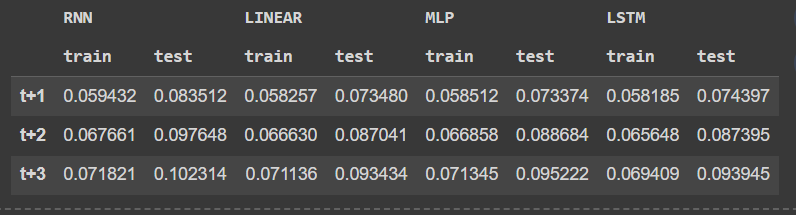

Pela tabela, tem-se que o modelo LSTM apresenta o melhor desempenho durante o treinamento, apresentando o menor valor de RSME nos três horizontes apresentados na tabela.

Quando é analisado o valor de RSME para o conjunto de teste, tem-se que no horizonte t+3 o modelo LINEAR apresenta um melhor desempenho do que o modelo do bloco LSTM, a diferença é pequena, mas há uma diferença. Uma vez que os dados são de natureza não-linear, existem algumas hipóteses que podem explicar esse comportamento, como por exemplo: alguma flutuação aleatória nos dados de teste, um possível *overfitting* durante o treinamento do modelo LSTM para prever o horizonte t+3 ou então um tamanho limitado do conjunto de dados.

Apesar desse fato, o modelo LSTM apresentou um desempenho superior nos casos observados, nos dados de treinamento e de teste.






### Unemployment Rate

Durante os blocos de código, foi obtida a tabela abaixo, que apresenta a raiz do erro quadrático médio (RMSE), para as diferentes abordagens de previsão de série temporal. Nessa tabela, é apresentado o comparativo do desempenho dos quatro modelos: RNN, Regressão Linear, MLP e LSTM.

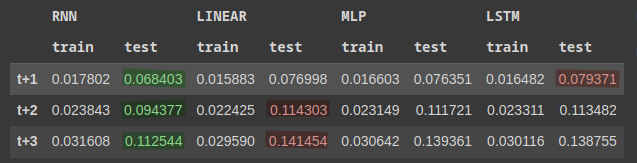

Para os dados de treinamento, o modelo linear foi o que apresentou o melhor ajuste, porém, ao aplicar tal modelo para os dados de teste, ele passa a apresentar o maior erro para os instantes $t+2$ e $t+3$. Como esse conjunto de dados possuí um evento irregular, causando pelo *lockdown* durante a pandemia de Covid-19 em 2020, contendo um padrão que não existe no conjunto de dados de treinamento, o modelo linear não consegue aproximar tal acontecimento, sendo a prova da sua grande falha. Porém, a rede neural recorrente (RNN) é a que se sai melhor na tarefa de prever a série temporal, mesmo durante o período de anormalidade, apresentando uma falha ao prever o pico de desemprego no início da pandemia, porém, com ótimas previsões da recuperação posterior. **[...]**


(d)	Ao se variar o [horizon], apresente uma hipótese para a perda de desempenho conforme [horizon] cresce de 1 até 3, comportamento produzido por todos os modelos de predição, nos dois casos de estudo.

**Resposta:**<BR> Ao prever um horizonte de 5 passos à frente, por exemplo, a previsão do próximo valor é utilizada como entrada para a previsão do valor subsequente, e assim por diante. Este processo de realimentação contínua dos valores previstos introduz e amplifica os erros a cada passo adicional, realizando a propagação do erro. Dessa forma, quanto maior o horizonte de previsão desejado, maior tende a ser o erro acumulado, resultando em uma redução no desempenho do modelo de predição.

Esse comportamento ocorre, porque os modelos de predição geralmente são menos precisos ao prever valores mais distantes no futuro devido à incerteza crescente e à possibilidade de desvios acumulativos a partir de erros iniciais de previsão, além da ocorrência de efeitos externos ser imprevisível. Logo, um horizonte de previsão mais longo amplifica a propagação dos erros, levando a uma queda de desempenho, como foi observado nos modelos analisados.

(e)	Ao se variar o [time_steps] especificamente para os modelos SimpleRNN e LSTM, procure explicar o comportamento observado em cada caso de estudo.

**Resposta:**

### Sunspot

Ao se variar os *time_steps* afeta o comportamento dos modelos RNN e LSTM de formas diferentes, como é mostrado a seguir:


**RNN**

Para o modelo de RNN simples, caso os dados recentes contiverem informações mais relevantes para prever valores fururos, *time_steps* baixos podem ser suficientes para que a RNN capture essas dependências e apresente um bom desempenho.

Já *time_steps* elevados podem ser prejudiciais as RNNs, devido ao risco de desaparecimento do gradiente. Nesse caso, os gradientes podem se tornar muito pequenas ou desaparecer durante o processo de retropropagação, o que dificulta a aprendizagem de informações passadas distantes e levando a um pior desempenho.


**LSTM**

Análogo ao modelo de RNN, *time_steps* baixos podem ser adequados se os dados recentes forem mais importante, no entanto, os blocos LSTMs possuem um mecanismo de memória interna que permite lidar com dependências um pouco mais longas do que as RNNs.

Aumentar os *time_steps* pode permitir que o LSTM acesse e utilize informações de uma janela histórica mais ampla, potencialmente melhorando a precisão da previsão. No entanto, caso os valores de *time_steps* sejam muito altos, há o risco de *overfitting* se os dados históricos adicionais incluírem ruído irrelevante.



*   Com base nos dados obtidos na tabela, é possível dizer que os LSTMs apresentam uma tendência a apresentar um desempenho superior tanto para dependêcias de curto quanto de longo prazo. Conforme o horizonte de previsão aumenta, os LSTMs geralmente apresentam um erro de teste menor em t+2, essa diferença de erro enre os modelos se torna visível em t+3. O que indica que o modelo utilizando blocos LSTM pode apresentar menores valores de RMSE para horizontes maiores.



### Unempolyment rate

A série de Unemployment Rate não é tão comportada quanto a Sunspot, dessa forma, observa-se que ocorre um fenômeno diferente do caso anterior. Observa-se que durante o treinamento, como anteriormente, o aumento do número de *time_steps* fez com que o erro diminuísse, havendo mais padrões passados para o preditor se basear para realizar a predição. Porém, para os casos de teste, ocorreu o inverso, onde quanto maior o número de amostras passadas utilizadas, maior foi o erro observado.

Tal comportamento ocorre devido a, durante o treinamento, a séria ser mais comportada, enquanto no conjunto de testa, existe um padrão inédito e irregular causado pelo *lockdown*. Dessa forma, quanto mais atrasos forem utilizados, mais o preditor tende a errar, pois uma vez que o evento ocorre, nenhuma amostra passada a ele se faz útil para a predição, ou seja, quanto mais atrasos nesse caso, mais rígida é a predição em termos de acompanhar o evento inédito.
